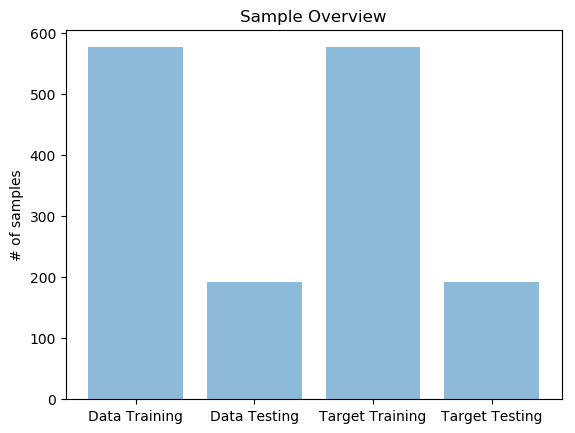

In [454]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

df = pd.read_csv("../Downloads/diabetes.csv")
targetDF = df[['Outcome']].copy()
testDF = df.drop(['Outcome'], axis=1).copy()

x_train, x_val, y_train, y_val = train_test_split(testDF, targetDF, test_size=0.25, shuffle=True)

objects = ('Data Training', 'Data Testing','Target Training', 'Target Testing')
y_pos = np.arange(len(objects))
performance = [len(x_train),len(x_val),len(y_train),len(y_val)]
 
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('# of samples')
plt.title('Sample Overview')

plt.show()

In [481]:
#@author Hercules Hjalmarsson

from statistics import mean
from sklearn.base import BaseEstimator
import math
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import time

class neuralNetwork(BaseEstimator):
    def __init__(self, hiddenLayerSize, iterations=10000, showLoss = False,overFitPrevention = False):
        self.iter = iterations
        self.showLossStatus = showLoss
        self.overFitP = overFitPrevention
        self.hls = hiddenLayerSize
    
    #Function to define the size of the layer
    def layer_sizes(self,X, Y):
        inputLayerSize = X.shape[0] # size of input layer
        hiddenLayerSize = self.hls# size of hidden layer
        outputLayerSize = Y.shape[0] # size of output layer
        return (inputLayerSize, hiddenLayerSize, outputLayerSize)
    
    #Math helper functions
    def sigmoid(self, s):
        return 1 / (1 + np.exp(-s))
    
    def sigmoidPrime(self, s):
        return 1 - s**2
        
    def softmax(self,inputData):
        exps = np.exp(inputData - np.max(inputData, axis=1, keepdims=True))
        return exps/np.sum(exps, axis=1, keepdims=True)
    
    def tanh_deriv(self,s):
        return 1.0 - np.tanh(s)**2
    
    def ReLU(self,s):
        return s * (s > 0)

    def dReLU(self,s):
        return 1. * (s > 0)
    
    #Computes the loss value
    def cross_entropy(self,y_pred, y_true):
        n_samples = y_true.shape[0]
        res = y_pred - y_true
        return res/n_samples
    
    def mse_loss(self,y_pred,y_true):
        # y_true and y_pred are numpy arrays of the same length.
        return ((y_true - y_pred) ** 2).mean()
    
    def fit(self,X,Y,LearnRate=0.5):
        # Initialize parameters
        self.n_x = self.layer_sizes(X, Y)[0]
        self.n_y = self.layer_sizes(X, Y)[2]
        #Stores the target value for accuracy comparison when evaluating
        self.targetData = Y
        self.W1 = np.random.randn(self.hls, self.n_x) * 0.01 #weight matrix of shape hiddenlayerSize, inputSize
        self.b1 = np.zeros(shape=(self.hls, 1))  #bias vector of shape (hiddenlayerSize, 1)
        self.W2 = np.random.randn(self.n_y, self.hls) * 0.01   #weight matrix of shape (outputSize, hiddenlayerSize)
        self.b2 = np.zeros(shape=(self.n_y, 1))  #bias vector of shape (outputSize, 1)
        #Model that can be saved/viewed
        self.internalModel = { 'W1': self.W1, 'b1': self.b1, 'W2': self.W2, 'b2': self.b2}
        #Train loop
        self.trainNeuralNetwork(LearnRate,X,Y)
             
    def trainNeuralNetwork(self,LearnRate,X,Y):
        # Loop (gradient descent)
        for i in range(self.iter):
            #Forward propagation: Inputs: X = data
            o = self.forwardPropagate(X)
            #Internal prediction: o = predicted output (Formatted)
            self.predictTargetVal = self.formatOutput(o)
            
            #Gets the loss value: Inputs: self.A2 = Prediction, Y = Target
            self.loss = self.mse_loss(self.A2,Y)

            # Backpropagation: Inputs: X = data, Y = Target
            self.backPropagate(X,Y)
            
            # Train the weights and biases
            self.trainWeightsAndBiases(LearnRate)
        
            #Map of model
            self.internalModel = { 'W1': self.W1, 'b1': self.b1, 'W2': self.W2, 'b2': self.b2}
            #If used, checks if loss$ rate is = 0 which may indicate overfitting
            if(self.overFitP):
                if(self.loss.sum() > 0.1 and self.loss.sum() < 0.2):
                    print("Well trained! Exiting training loop.")
                    print(" Loss: %f Accuracy: %f" % (self.loss.sum(),self.evaluate(X,Y,True)))
                    break
                elif(self.loss.sum() < 0.1):
                    print("Overfit detected! Retraining model")
                    print("Error Rate: %f Accuracy: %f" % (self.loss.sum(),self.evaluate(X,Y,True)))
                    self.retrain()
            # Print the loss value every 100 iterations
            if(self.showLossStatus and (i % 100) == 0):
                print(" Loss: %f Accuracy: %f" % (self.loss.sum(),self.evaluate(X,Y,True)))
                
    # Gradient descent parameter update
    def trainWeightsAndBiases(self,learningRate):
        # Update rule for each parameter
        #dW1,dW2,db1,db2 comes from backward propagate function
        self.W1 = self.W1 - learningRate * self.dW1
        self.W2 = self.W2 - learningRate * self.dW2
        self.b1 = self.b1 - learningRate * self.db1
        self.b2 = self.b2 - learningRate * self.db2
    
    def retrain(self):
        self.W1 = np.random.randn(self.hls, self.n_x) * 0.01 #weight matrix of shape (hiddenLayerSize, inputLayerSize)
        self.b1 = np.zeros(shape=(self.hls, 1))  #bias vector of shape (hiddenLayerSize, 1)
        self.W2 = np.random.randn(self.n_y, self.hls) * 0.01   #weight matrix of shape (OutputLayerSize, hiddenLayerSize)
        self.b2 = np.zeros(shape=(self.n_y, 1))  #bias vector of shape (OutputLayerSize, 1)
        
    #Predict function which outputs the model predicted values
    def predict(self,testData):
        outputSize = 0
        try:
            outputSize = testData.shape[0]
        except:
            outputSize = 1
            
        shouldCorrectOutput = False
        if(testData.shape[0] != self.W1.shape[1]):
            shouldCorrectOutput = True
            if(testData.shape[0] < self.W1.shape[1]):
                while testData.shape[0] < self.W1.shape[1]:
                    testData = np.append(testData, testData, axis = 0)

                for i in reversed(range(self.W1.shape[1])):
                    if(testData.shape[0] > self.W1.shape[1]):
                        testData = np.delete(testData,i,axis = 0)
            else:
                for i in reversed(range(self.W1.shape[1])):
                    if(testData.shape[0] > self.W1.shape[1]):
                        testData = np.delete(testData,i,axis = 0)
        
        self.A2 = self.forwardPropagate(testData)
        if(shouldCorrectOutput):
            for i in reversed(range(self.W1.shape[1])):
                if(self.A2.shape[0] > outputSize):
                    self.A2 = np.delete(self.A2, i, axis = 0)
            return self.A2
        else:
            return self.A2
    
    #Forward propagation function to get a prediction by the using the models weights and biases
    def forwardPropagate(self,X):
        self.Z1 = np.add(np.matmul(self.W1, X), self.b1)
        self.A1 = np.tanh(self.Z1)
        self.Z2 = np.add(np.matmul(self.W2, self.A1), self.b2)
        self.A2 = self.sigmoid(self.Z2)
        return self.A2
    
    #Backwards propagation function to train the model with the predictions given by the forward propogate
    def backPropagate(self,X,Y):
        m = X.shape[1]
        dZ2 = self.A2 - Y
        self.dW2 = (1.0/m) * np.matmul(dZ2, np.transpose(self.A1)) + (0.7/m)*self.W2 #regularization
        self.db2 = (1.0/m) * np.sum(dZ2, axis=1, keepdims=True)
    
        dZ1 = np.matmul(np.transpose(self.W2), dZ2) * self.sigmoidPrime(self.A1)
        self.dW1 = (1.0/m) * np.matmul(dZ1, np.transpose(X)) + (0.7/m)*self.W1 #regularization
        self.db1 = (1.0/m) * np.sum(dZ1, axis=1, keepdims=True)
    
    #Functions which formats the output predictions correctly
    def formatOutput(self,output):
        getOutput = []
        for i in range(len(output)):
            getOutput.append(mean(output[i]))
        
        return getOutput
    
    #Function which evaluates the training and testing accuracy of the model
    def evaluate(self,testData,targetData,showTrainingAccuracy = False, showTestAccuracy = False):
        
        if(showTrainingAccuracy):
            temp = []
            accuracyT = 0
            for v in self.predictTargetVal: 
                if(v < 0.5):
                    temp.append(0)
                else:
                    temp.append(1)

            for j in range(len(self.targetData)):
                if(temp[j] == self.targetData[j]):
                    accuracyT += 1;
            
        if(showTestAccuracy):
            output = self.predict(testData)
            
            for i in range(len(output)):
                if(mean(output[i]) > 0.5):
                    output[i] = 1;
                else:
                    output[i] = 0;
            
            valid = targetData
            accuracy = 0 
            for i in range(len(valid)):
                if(mean(output[i]) == valid[i]):
                    accuracy += 1

        if(showTrainingAccuracy and showTestAccuracy):
            return accuracyT/len(self.targetData),accuracy/len(valid)
        
        if(showTrainingAccuracy):
            return accuracyT/len(self.targetData)
        
        if(showTestAccuracy):
            return accuracy/len(valid)

In [482]:
X = x_train.values
Y = y_train.values
hiddelLayer = int(X.shape[0]*(2/3) + Y.shape[0])

In [483]:
start_time = time.time()
nn = neuralNetwork(hiddenLayerSize = hiddelLayer,iterations = 200, showLoss = True, overFitPrevention = False)
model = nn.fit(X,Y,LearnRate = 0.5)
elapsed_time = time.time() - start_time
print("seconds: %f" %(elapsed_time))

 Loss: 0.254767 Accuracy: 0.510417
 Loss: 0.000001 Accuracy: 1.000000
seconds: 12.418403


In [476]:
trainingA, testA = nn.evaluate(x_val.values,y_val.values,showTrainingAccuracy=True,showTestAccuracy=True)
print ("Training Accuracy: %f Test Accuracy: %f" % (trainingA,testA))

Training Accuracy: 1.000000 Test Accuracy: 0.593750


In [477]:
from sklearn.metrics import classification_report
y_pred = nn.predict(x_val.values)
predictions_mod = []
count = 0
for i in y_pred:
    if(mean(i) > 0.5):
        predictions_mod.append(1)
    else:
        predictions_mod.append(0)
    count += 1

target_names = ['Negative', 'Positive']
print(classification_report(y_val.values, predictions_mod, target_names=target_names))

             precision    recall  f1-score   support

   Negative       0.71      0.69      0.70       132
   Positive       0.36      0.38      0.37        60

avg / total       0.60      0.59      0.60       192



In [468]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
start_time = time.time()
#model_nn.summary()

model_nn = Sequential()
model_nn.add(Dense(hiddelLayer,input_shape=(X.shape[1],), activation='sigmoid'))
model_nn.add(Dense(1, activation='sigmoid'))
model_nn.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['accuracy'])
model_nn.fit(x_train, y_train, epochs=200, verbose=0)
elapsed_time = time.time() - start_time 
print("seconds: %f" %(elapsed_time))
out = model_nn.evaluate(x_train,y_train)
print("Loss:",out[0])
print("Accuracy:",out[1])

seconds: 25.928462
576/576 [==============================] - 1s 930us/step
Loss: 0.4928353561295403
Accuracy: 0.7361111111111112


In [400]:
out = model_nn.evaluate(x_val,y_val)
print("Loss:",out[0])
print("Accuracy:",out[1])

192/192 [==============================] - 0s 2ms/step
Loss: 6.715873161951701
Accuracy: 0.5833333333333334


In [470]:
from sklearn.metrics import classification_report

y_pred = model_nn.predict(x_val)

for i in range(len(y_pred)):
    if(y_pred[i] > 0.5):
        y_pred[i] = 1
    else:
        y_pred[i] = 0

target_names = ['Negative', 'Positive']
print(classification_report(y_val.values, y_pred, target_names=target_names))

             precision    recall  f1-score   support

   Negative       0.76      0.95      0.85       132
   Positive       0.77      0.33      0.47        60

avg / total       0.76      0.76      0.73       192

